In [328]:
# GENERAL IMPORTS
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
from pprint import pprint
# from collections import deque

# FILE IMPORTS
from config_file import Config

conf = Config()
ROOT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))

In [329]:
folders = glob.glob(os.path.join(ROOT_DIR, "data", "stereodataset", "*"))
N_IMAGES = len(folders)

dataset = []

for folder in folders:
    with open(os.path.join(folder, "param_in.txt")) as f:
        params = f.readlines()
        data = {
            "name": os.path.abspath(folder),
            "ref": params[0].split(" ")[1].strip(),
            "gt": params[1].split(" ")[1].strip(),
            "disp_min": int(params[3].split(" ")[1].strip()),
            "disp_max": int(params[4].split(" ")[1].strip()),
            "disp_scale": int(params[5].split(" ")[1].strip()),
            "ignore_border": int(params[7].split(" ")[1].strip())
        }

        data["disp_range"] = range(data["disp_min"], data["disp_max"])
        dataset.append(data)


def display_img_standard(img):
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap="gray", vmin=0, vmax=np.max(img))
         

def read_image(path):
        print("img path {}".format(path))
    # if path.split(".")[-1] == "pgm":
        img = cv2.imread(path, -1)
        print(img.shape)
        plt.figure(figsize=(5,3))
        if len(img.shape) == 2:
            plt.imshow(img, cmap="gray", vmin=0, vmax=255)
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
        return img


/home/franchetto4/github/ComputerVision/data/stereodataset/map
img path /home/franchetto4/github/ComputerVision/data/stereodataset/map/im1.pgm
(216, 284)


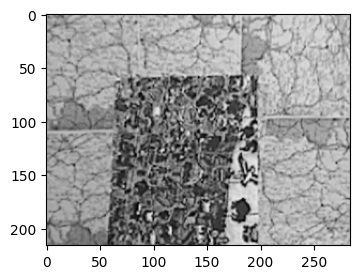

img path /home/franchetto4/github/ComputerVision/data/stereodataset/map/im0.pgm
(216, 284)


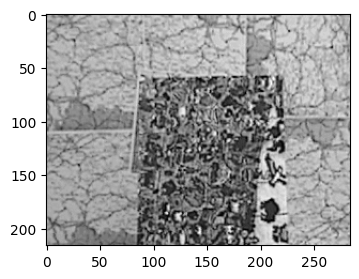

img path /home/franchetto4/github/ComputerVision/data/stereodataset/map/disp1.pgm
(216, 284)


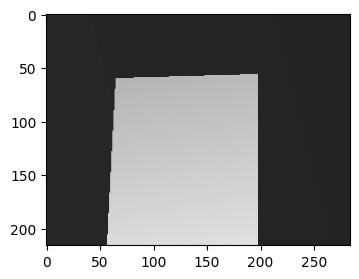

/home/franchetto4/github/ComputerVision/data/stereodataset/venus
img path /home/franchetto4/github/ComputerVision/data/stereodataset/venus/im6.ppm
(383, 434, 3)


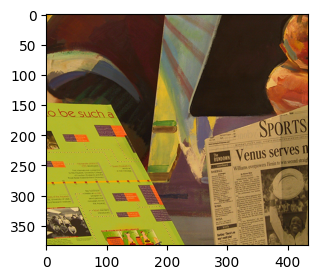

img path /home/franchetto4/github/ComputerVision/data/stereodataset/venus/im2.ppm
(383, 434, 3)


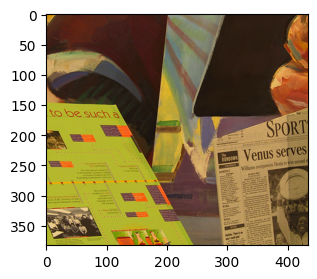

img path /home/franchetto4/github/ComputerVision/data/stereodataset/venus/disp6.pgm
(383, 434)


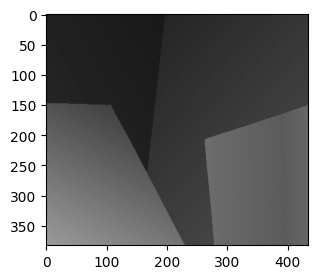

/home/franchetto4/github/ComputerVision/data/stereodataset/sawtooth
img path /home/franchetto4/github/ComputerVision/data/stereodataset/sawtooth/im6.ppm
(380, 434, 3)


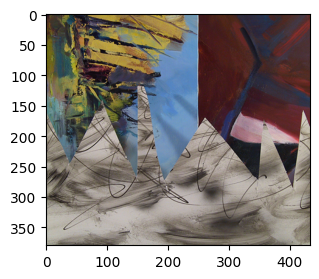

img path /home/franchetto4/github/ComputerVision/data/stereodataset/sawtooth/im2.ppm
(380, 434, 3)


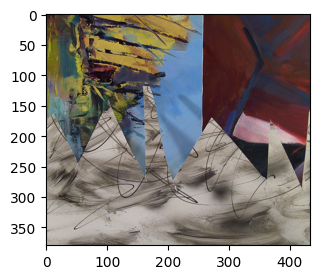

img path /home/franchetto4/github/ComputerVision/data/stereodataset/sawtooth/disp6.pgm
(380, 434)


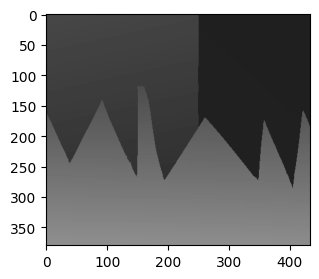

/home/franchetto4/github/ComputerVision/data/stereodataset/tsukuba
img path /home/franchetto4/github/ComputerVision/data/stereodataset/tsukuba/scene1.row3.col2.ppm
(288, 384, 3)


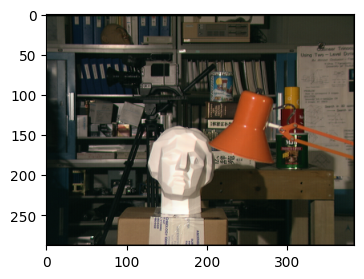

img path /home/franchetto4/github/ComputerVision/data/stereodataset/tsukuba/scene1.row3.col3.ppm
(288, 384, 3)


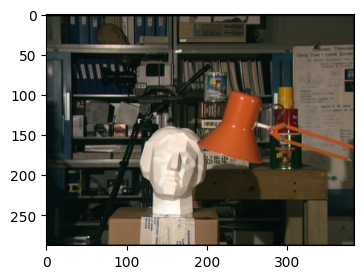

img path /home/franchetto4/github/ComputerVision/data/stereodataset/tsukuba/truedisp.row3.col3.pgm
(288, 384)


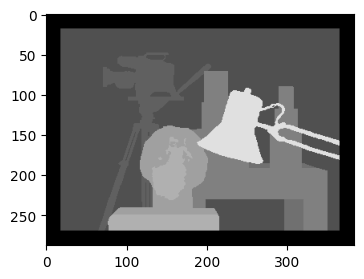

In [330]:
for i, data in enumerate(dataset):
    print(data["name"])

    left_img_full_path = os.path.join(folders[i], data["ref"])
    data["left_img"] = read_image(left_img_full_path)

    left_img_path = data["ref"]
    init_char = left_img_path[0]
    extension = left_img_path.split(".")[-1]
    right_img_format = init_char + "*." + extension
    right_img_path = glob.glob(os.path.join(folders[i], right_img_format))
    right_img_path.remove(left_img_full_path)
    if len(right_img_path) > 1:
        raise ValueError("Too many images with format {}".format(right_img_format))
    else:
        right_img_path = right_img_path[0]

    data["right_img"] = read_image(right_img_path)
    
    data["disp_map"] = read_image(os.path.join(folders[i], data["gt"]))


In [331]:
def pad_to_img_size(img, monochannel_img):
    h, w = img.shape[:2]
    h_m, w_m = monochannel_img.shape

    if h-h_m == w-w_m:
        pad_size = int((h-h_m) / 2)
        print(pad_size)
    else:
        raise ValueError("Mask is not smaller by the same constant in height and width wrt the image")

    return np.pad(monochannel_img, pad_size)

In [332]:
def check_img_channels(img1, img2) -> bool:
    '''
    Returns True if both are RGB, False is grayscale, raises an error otherwise
    '''
    if len(img1.shape) != len(img2.shape):
        raise ValueError("The two images mush have the same numbero of channels: img1 shape = {} and img2 shape = {}".format(img1.shape, img2.shape))
    elif len(img1.shape) == 3:
        if img1.shape[-1] == 3:
            rgb_flag = True
        elif img1.shape[-1] == 1:
            rgb_flag = False
        else:
            raise ValueError("The images can either have 3 channels (RGB) or 1 (grayscale): # of channels of img1 = {}".format(img1.shape[-1]))
        
    return rgb_flag


def SAD(img1, img2, k, disparity_range, search_area=False, zero_meaned=False):
    '''
    Returns a matrix [h-2k, w-2k, d] with NCC value for each pixel and disparity in disparity range
    You will need to compute at least a np.max on the last axis to use it
    '''
    # compute the Normalized Cross Correlation
    #  between intensities of the two images
    # in disparity map computation you only need to compare the left pixel (and patch around it) with an horizontal segment in the right image (the disparity_range)
    if search_area != False:
        i_min, i_max, j_min, j_max = search_area
    else:
        h, w = img1.shape[:2]
        i_min = k
        i_max = h-k
        j_min = k
        j_max = w-k

    up_lim =    i_min-k
    down_lim =  i_max+k+1
    left_lim =  j_min-k
    right_lim = j_max+k+1

    disparity_maps = np.zeros((i_max-i_min, j_max-j_min, len(disparity_range)))

    if zero_meaned:
        mean_filter = np.ones((k,k)) / (k*k)
        means_img1 = cv2.filter2D(img1, -1, mean_filter, (-1, -1))
        means_img2 = cv2.filter2D(img2, -1, mean_filter, (-1, -1))
        img1 = (img1 - means_img1)
        img2 = (img2 - means_img2)
        
    # compute SAD for each pixel patch wrt its "disparity counterpart" for each d value
    img1_area = img1[up_lim:down_lim, left_lim:right_lim, ...]

    for d in disparity_range:
        # for some pixels with high "j", high disparity numbers would bring the patch outside the image
        img2_area = img2[ up_lim:down_lim, left_lim+(d):right_lim+(d),   ...]
        if img2_area.shape != img1_area.shape: # if the above happens, we pad with zeros
            pad_size = right_lim+(d) - w
            padded_img2_area = np.zeros_like(img1_area)
            padded_img2_area[:, :-pad_size+1, ...] = img2_area
            img2_area = padded_img2_area
        
        disparity_pixelwise = np.int64(np.abs(img1_area - img2_area))

        # compute the sum over the patches (and over the channels if RGB)
        tmp = cv2.filter2D(disparity_pixelwise, -1, np.ones((k,k)), (-1,-1))
        tmp = tmp[i_min:i_max, j_min:j_max, ...]
        if len(tmp.shape) == 3:
            tmp = np.sum(tmp, axis=-1)
        
        disparity_maps[:, :, d] = tmp

        # by hand
        # for i in range(i_min, i_max):
        #     for j in range(j_min, j_max):
        #         disparity_maps[i-k, j-k, d] = np.sum(disparity_pixelwise[i-k:i+k, j-k:j+k, ...])
                
    return disparity_maps

In [333]:
# need to compute the min along disparity axis to find disparity for each pixel
disparity_maps = SAD(dataset[0]["left_img"], dataset[0]["right_img"], k=19, disparity_range=conf.d_range)
dataset[0]["SAD"] = disparity_maps
disparity_map = np.argmin(disparity_maps, axis=-1)

In [334]:
np.max(disparity_maps)

78113.0

In [335]:
def show_disp_and_imgs(img1, img2, disparity_map, name=""):
    fig, axs = plt.subplots(1, 3, figsize=(12, 5), constrained_layout=True)

    fig.suptitle(name, fontsize=15)

    axs[0].axis("off")
    axs[0].set_title("left_img")
    if len(img1.shape) == 2:
        axs[0].imshow(img1, cmap="gray", vmin=0, vmax=255)
    else:
        axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

    axs[1].axis("off")
    axs[1].set_title("right_img")
    if len(img2.shape) == 2:
        axs[1].imshow(img2, cmap="gray", vmin=0, vmax=255)
    else:
        axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

    axs[2].axis("off")
    axs[2].set_title("disparity_map")
    axs[2].imshow(disparity_map, cmap="gray", vmin=0, vmax=len(conf.d_range))
    plt.show()

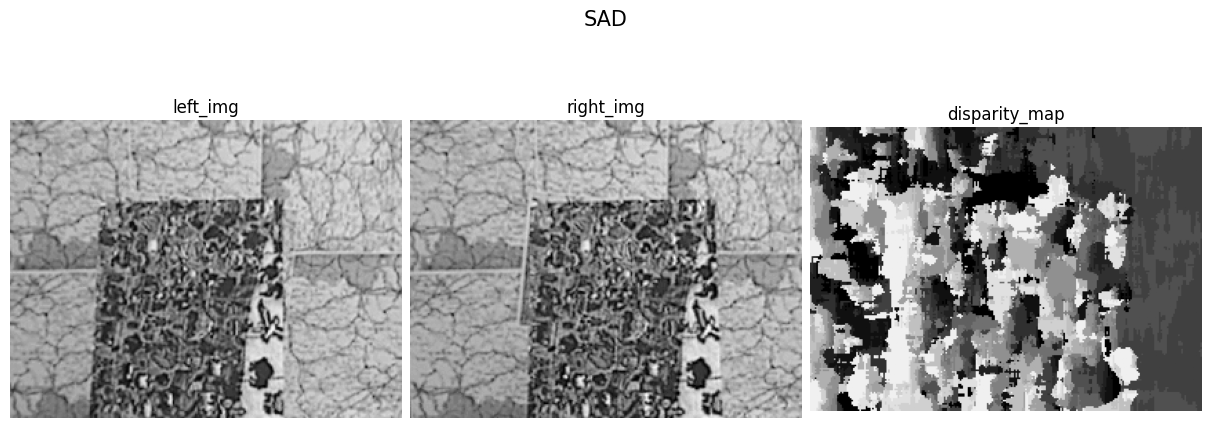

In [336]:
show_disp_and_imgs(dataset[0]["left_img"], dataset[0]["right_img"], disparity_map, "SAD")

In [337]:
def evaluation_dense(gt, prediction, disp_scale, ignore_border=0):
    '''
    Better when LOWER
    eval = mean "correctness", where correctness of a disparity measure is 0 if the error is <= 1, 1 otherwise
    '''
    # reduce the gt disparity_map by its scale
    gt = gt/float(disp_scale)
    prediction = pad_to_img_size(gt, prediction)
    h, w = gt.shape[:2]
    b = ignore_border
    difference = np.abs(gt[b:h-b+1, b:w-b+1] - prediction[b:h-b+1, b:w-b+1]) - 1 # min_value is -1
    
    difference = np.minimum(difference, 1) # cap the image to max_value = 1
    difference = np.maximum(difference, 0) # cap the image to min_value = 0
    plt.imshow(difference, cmap="gray", vmin=0, vmax=1)
    return np.mean(difference)

19


0.7399690136385226

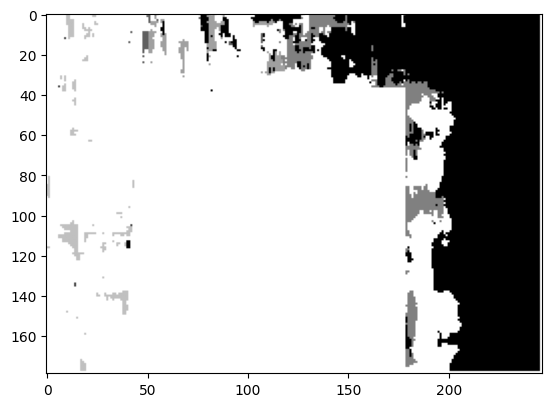

In [338]:
evaluation_dense(dataset[0]["disp_map"], disparity_map, disp_scale=dataset[0]["disp_scale"], ignore_border=19)

In [339]:
def moravec(img):
    '''
    Returns "cornerness" of each pixel through the moravec operator
    The returned matrix is reduced on all sides by 1 pixel, because moravec operator
    '''
    directional_differences = []
    h,w = img.shape[:2]
    for m in range(-1, 2):
        for n in range(-1, 2):
            if m == 0 and n == 0:
                pass
            else:
                difference = np.square(img[1:-1, 1:-1, ...] - img[1+m:h-1+m, 1+n:w-1+n, ...])
                if len(img.shape) == 3:
                    # check (1+m:-1+m --> not always negative)
                    difference = np.sum(difference, axis=-1)

                directional_differences.append(difference)

    directional_differences = np.stack(directional_differences, axis=-1)
    min_difference = np.min(directional_differences, axis=-1)

    return min_difference


def get_moravec_mask(img, minimum_interestingness_threshold):
    img_interestingness = moravec(img)
    return img_interestingness > minimum_interestingness_threshold

False
True
0.027739113143766158


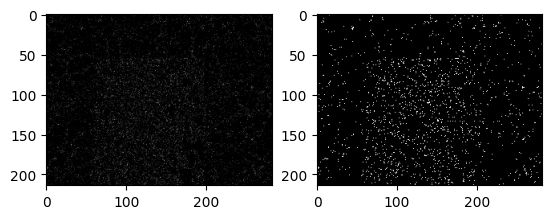

In [340]:
plt.subplot(121)
plt.imshow(moravec(dataset[0]["left_img"]), cmap="gray", vmin=0, vmax=255)
plt.subplot(122)

mask = get_moravec_mask(dataset[0]["left_img"], 50)
print(np.min(mask))
print(np.max(mask))
print(np.mean(mask))

plt.imshow(mask, cmap="gray", vmin=0, vmax=1)
plt.show()

In [341]:
def find_peaks(arr):
    deriv = arr[1:] - arr[:-1]
    
    mask_left_deriv = np.concatenate([np.array([True]), deriv>0]) # add a true because we want to allow LAST value to be "peak" 
    mask_right_deriv = np.concatenate([deriv<0, np.array([True])]) # add a true because we want to allow LAST value to be "peak" 
    is_peak = np.multiply(mask_left_deriv, mask_right_deriv)
    return is_peak, deriv

In [342]:
a = np.array([8, 4, 2, 6, -3])
is_peak, deriv = find_peaks(a)
is_peak

array([ True, False, False,  True, False])

In [354]:
def get_disparity_mask(disparity_map, th_ratio, th_peak):
    '''
    Returns a boolean mask with 0 if a pixel doesn't have a "good" maximum in its disparity values,
    1 otherwise
    '''
    h, w = disparity_map.shape[:2]
    disparity_mask = np.ones((h, w))

    
    c1, c2 = 0, 0
    for i in range(h):
        for j in range(w):
            disparities = disparity_map[i, j, :]
            is_peak, deriv = find_peaks(disparities)
            peaks = list(np.multiply(disparities, is_peak))

            peak_1_idx = np.argmax(peaks)

            peak_1_value = peaks[peak_1_idx]
            peaks[peak_1_idx] = 0

            peak_2_value = np.max(peaks)

            if peak_2_value > peak_1_value*th_ratio:
                disparity_mask[i, j] = 0
                c1+=1
            
            if peak_1_idx == 0:
                if np.abs(deriv[0]) < th_peak:
                    disparity_mask[i, j] = 0
            elif peak_1_idx == len(disparities)-1:
                if np.abs(deriv[-1]) < th_peak:
                    disparity_mask[i, j] = 0
            else:
                if np.abs(deriv[peak_1_idx-1]) + np.abs(deriv[peak_1_idx]) < 2*th_peak:
                    disparity_mask[i, j] = 0
                    c2+=1

    print("Black = rejected. \n"+\
            "Total points = {} \n".format(h*w)+\
            "Rejected because ratio 2nd/1st peak too high {} \n".format(c1)+\
            "Rejected because bad peak spread {}".format(c2))
            
    return disparity_mask

Black = rejected. 
Total points = 43788 
Rejected because ratio 2nd/1st peak too high 14988 
Rejected because bad peak spread 5558


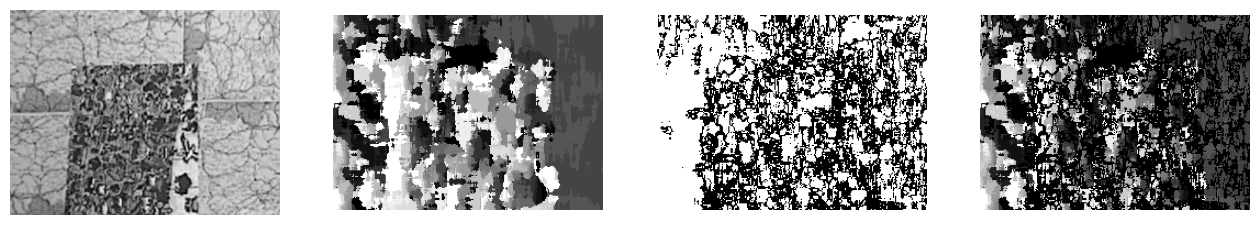

In [355]:
plt.figure(figsize=(16, 9))
plt.subplot(141)
plt.axis("off")
display_img_standard(dataset[0]["left_img"])
plt.subplot(142)
plt.axis("off")
disparity_map = np.argmin(dataset[0]["SAD"], axis=-1)
display_img_standard(disparity_map)
plt.subplot(143)
plt.axis("off")
disparity_mask = get_disparity_mask(dataset[0]["SAD"], 0.98, 1000)
display_img_standard(disparity_mask)
plt.subplot(144)
plt.axis("off")
display_img_standard(np.multiply(disparity_map, disparity_mask))
plt.show()


In [ ]:
def evaluation_sparse(gt_disparity, prediction_disparity, interest_mask=False, disparity_mask=False, ignore_border=0):
    '''
    Returns mean correctness of disparity prediction taking into account ONLY:
        - interest_mask: the pixels of the image on which we want to compute disparity
        - disparity_mask: the pixels of the image in which the disparity maximum was accepted
    '''
    # pads all the inputs to the gt_disparity shape, so that multiplication works well
    prediction_disparity = pad_to_img_size(gt_disparity, prediction_disparity)

    if disparity_mask == False:
        disparity_mask = np.ones_like(prediction_disparity)
    else:
        disparity_mask = pad_to_img_size(gt_disparity, disparity_mask)

    if interest_mask == False:
        interest_mask = np.ones_like(prediction_disparity)
    else:
        interest_mask = pad_to_img_size(gt_disparity, interest_mask)

    final_mask = np.multiply(interest_mask, disparity_mask)
    N_area = np.sum(final_mask)

    h, w = gt_disparity.shape[:2]
    b = ignore_border
    difference = np.abs(gt_disparity[b:h-b+1, b:w-b+1] - prediction_disparity[b:h-b+1, b:w-b+1]) # min_value is 0
    difference = np.minimum(difference, 1) # cap the image to max_value = 1
    difference = np.multiply(difference, final_mask)

    accuracy = np.sum(difference) / N_area
    accepted_pixels_percentage = N_area / (h*w)
    return accuracy, accepted_pixels_percentage

In [ ]:
def NCC(img1, img2, k, disparity_range, search_area=False, zero_meaned=False):
    '''
    Returns a matrix [h-2k, w-2k, d] with NCC value for each pixel and disparity in disparity range
    You will need to compute at least a np.max on the last axis to use it
    '''
    # compute the Normalized Cross Correlation
    #  between intensities of the two images
    # in disparity map computation you only need to compare the left pixel (and patch around it) with an horizontal segment in the right image (the disparity_range)
    if search_area != False:
        i_min, i_max, j_min, j_max = search_area
    else:
        h, w = img1.shape[:2]
        i_min = k
        i_max = h-k
        j_min = k
        j_max = w-k

    disparity_map = np.zeros((i_max-i_min, j_max-j_min, len(disparity_range)))

    if zero_meaned:
        mean_filter = np.ones((k,k)) / (k*k)
        means_img1 = cv2.filter2D(img1, -1, mean_filter, (-1, -1))
        means_img2 = cv2.filter2D(img2, -1, mean_filter, (-1, -1))
        img1 = (img1 - means_img1)
        img2 = (img2 - means_img2)
        
    # compute SAD for each pixel patch wrt its "disparity counterpart" for each d value
    img1_area = img1[i_min-k:i_max+k+1, j_min-k:j_max+k+1,           ...]
    img1_area_sq = np.square(img1_area)

    for d in disparity_range:
        # for some pixels with high "j", high disparity numbers would bring the patch outside the image
        img2_area = img2[ i_min-k:i_max+k+1, j_min-k+(d):j_max+k+1+(d),   ...]
        if img2_area.shape == img1_area.shape:
            disparity_pixelwise = np.abs(img1_area - img2_area)
        else: # if the above happens, we pad with zeros
            pad_size = j_max+k+1+(d) - w
            tmp = np.zeros_like(img1_area)
            tmp[:, :-pad_size, ...] = img2_area
            img2_area = tmp
        
        img2_area_sq = np.square(img1_area)

        numerator_pixelwise = np.multiply(img1_area, img2_area)
        
        # compute the sum over the patches (and over the channels if RGB)
        for i in range(i_min, i_max+1):
            for j in range(j_min, j_max+1):
                denominator = np.sqrt(np.sum(img1_area_sq[i-k:i+k+1, j-k:j+k+1, ...])) \
                    * np.sqrt(np.sum(img2_area_sq[i-k:i+k+1, j-k:j+k+1, ...]))
                disparity_map[i, j, d] = np.sum(numerator_pixelwise[i-k:i+k+1, j-k:j+k+1, ...]) / denominator
                
    return disparity_map